In [ ]:
#coding: UTF-8
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
import mpl_toolkits.mplot3d
 

In [12]:
#------------------------------------------------------------------------------
# DEFINITION
#------------------------------------------------------------------------------
class RLMomentum():
    def __init__(self, datapath):
        self.data = pd.read_csv(datapath, header=None)
        self.data = self.data.iloc[:,0]
        self.ret = self.data / self.data.shift(1) - 1
        self.ret = self.ret.fillna(0)
       
        self.window_short = 20
        self.window_long = 60
        self.samples = len(self.data)
        self.states = 6
        self.actions = 3 #long, flat, short
        self.epsilon = 0.1
        self.gamma = 0.9 #discount factor
        self.mc = 10 #Monte Carlo
 
        self.q = np.zeros((self.states, self.states, self.actions))
        self.rewards = np.zeros((self.states, self.states, self.actions))
        self.count = np.zeros((self.states, self.states, self.actions), dtype = np.int16)
        self.isVisited = np.zeros((self.states, self.states, self.actions), dtype = np.bool)
 
        self.momentum = np.zeros(self.samples)
   
    def init(self):
        self.count = np.zeros((self.states, self.states, self.actions), dtype = np.int16)
        self.isVisited = np.zeros((self.states, self.states, self.actions), dtype = np.bool)
   
    def currentState(self, signal):
        signal = float(signal)
        sep = np.linspace(-1, 1, self.states-1)
        return sum(sep < signal)
        
    def selectAction(self, state_short, state_long):
        if (self.q[state_short, state_long, :]==0).sum() == self.actions:
            #if all action-values are 0
            return np.random.randint(0, self.actions)
        else:
            #Epsilon-Greedy
            if np.random.random(1) < self.epsilon:
                return np.random.randint(0, self.actions)
            else:
                return np.argmax(self.q[state_short, state_long, :])
 
    def actionToPosition(self, action):
        if action == 0:
            return -1
        elif action == 1:
            return 0
        elif action == 2:
            return 1
 
    def updateRewards(self, reward, state_short, state_long, action):
        self.isVisited[state_short, state_long, action] = True
        #print(reward)
        #print(self.rewards)
        self.rewards = self.rewards + reward * (self.gamma ** self.count)
        self.count = self.count + self.isVisited
 
    def updateQ(self, itr):
        self.q = (self.q * itr + self.rewards) / (itr + 1)
 
    def episode(self):
        #print(self.data.head())
        #print(self.ret)
        for i in range(self.samples - 1):
            if i <= self.window_long - 1:
                self.momentum[i] = self.ret.ix[i]
            else:
                sub_short = self.momentum[i - self.window_short : i - 1]
                sub_long = self.momentum[i - self.window_long : i - 1]
               
                #state = annualized Sharpe ratio
                state_short = self.currentState( np.mean(sub_short) / np.std(sub_short) * np.sqrt(252) )
                state_long = self.currentState( np.mean(sub_long) / np.std(sub_long) * np.sqrt(252) )
 
                action = self.selectAction(state_short, state_long)
 
                reward = self.ret.ix[i + 1] * self.actionToPosition(action)
                self.updateRewards(reward, state_short, state_long, action)
           
                self.momentum[i] = reward
 
    def monteCarlo(self):
        for i in range(self.mc):
            self.init()
            self.episode()
            print("episode",i,"done. cumulative return is",sum(self.momentum))
            self.updateQ(i)
       
            plt.plot(100 * (1 + self.momentum).cumprod(), label="RL-momentum "+str(i))
 
        plt.plot(100 * (1 + self.ret).cumprod(), label="long-only")
        plt.plot(100 * (1 + self.momentum).cumprod(), label="RL-momentum")
        plt.legend(loc="best")
        plt.show()
       
        #plot Q-value matrix
        x = np.linspace(0,5,self.states)
        y = np.linspace(0,5,self.states)
        x,y = np.meshgrid(x, y)
       
        for i in range(self.actions):
            if i == 0:
                position = "short"
            elif i == 1:
                position = "flat"
            elif i == 2:
                position =  "long"
 
            fig = plt.figure()
            ax = fig.gca(projection='3d')
           
            ax.set_xlabel("state_short")
            ax.set_ylabel("state_long")
            ax.set_zlabel("Q-value")
            ax.set_title("Q-value for " + position + " position")
            #ax.view_init(90, 90)
            urf = ax.plot_surface(x, y, self.q[:, :, i], rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
 
            plt.show()

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in power
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in add


episode 0 done. cumulative return is 0.003290725752893686
episode 1 done. cumulative return is -0.18112419752552478
episode 2 done. cumulative return is -0.4942398728713673
episode 3 done. cumulative return is -0.10507966326768292
episode 4 done. cumulative return is -0.0700287051993137
episode 5 done. cumulative return is -0.06799968167481873
episode 6 done. cumulative return is -0.20857156846037572
episode 7 done. cumulative return is -0.3925499170093941
episode 8 done. cumulative return is -0.38573693711369694
episode 9 done. cumulative return is -0.34012984803671664


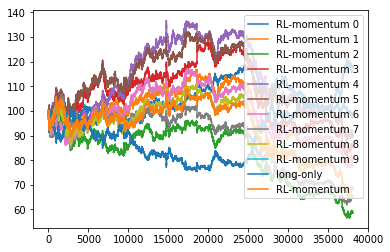

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


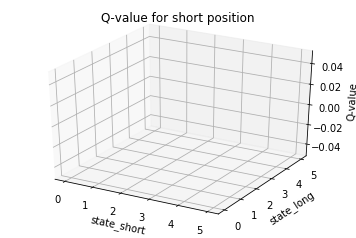

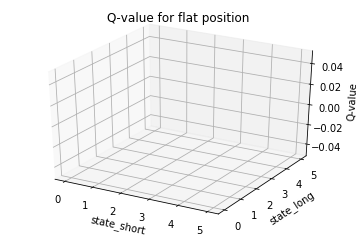

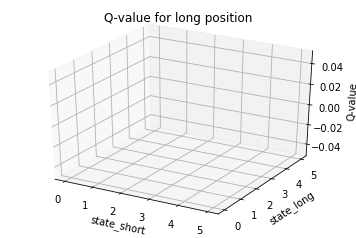

In [13]:
#------------------------------------------------------------------------------
# MAIN
#------------------------------------------------------------------------------
m = RLMomentum("usdjpy.csv")
m.monteCarlo()